# Localization Pipeline

In [94]:
import os
from tqdm import tqdm

ROOT_DIR = "/home/cayetana/Storage/code/heart-segmentation"
MMWHS_DIR = "data/datasets/MM-WHS 2017 Dataset"
WHS_CHD_DIR = "data/datasets/WHS CHD MICCAI19 Dataset"
MM_WHS_CHD_LOC_DIR = "data/datasets/MM-WHS-CHD Localization Dataset"

os.chdir(ROOT_DIR)

In [95]:
mmwhs_label_map = {
    "left ventricle": {"color": "yellow", "value": 500.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 600.0, "description": "the right ventricle blood cavity"},
    "ascending aorta": {"color": "orange", "value": 820.0, "description": "the ascending aorta"},
}

whs_chd_label_map = {
    "left ventricle": {"color": "yellow", "value": 1.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 2.0, "description": "the right ventricle blood cavity"},
    "ascending aorta": {"color": "orange", "value": 6.0, "description": "the ascending aorta"},
}

## Localization Dataset Collection

### MM-WHS Dataset Preprocessing

In [96]:
def collect_images_labels(image_dir : str, label_dir : str) -> list[dict[str, str]]:
    images = sorted(os.listdir(image_dir))
    labels = sorted(os.listdir(label_dir))
    
    data = []
    for image, label in zip(images, labels):
        data.append({"image": os.path.join(image_dir, image),
                     "label": os.path.join(label_dir, label)})
        
    return data
    
data = collect_images_labels(os.path.join(MMWHS_DIR, "images"),
                             os.path.join(MMWHS_DIR, "labels"))

data[0]

{'image': 'data/datasets/MM-WHS 2017 Dataset/images/ct_train_1001_image.nii.gz',
 'label': 'data/datasets/MM-WHS 2017 Dataset/labels/ct_train_1001_label.nii.gz'}

#### Zooming & Uniting

In [ ]:
import numpy as np
import scipy.ndimage

import re
import nibabel as nib
from tqdm import tqdm

def zoom(array : np.ndarray, target_shape : tuple[int, int, int], order : int=3) -> np.ndarray:
    scales = [ts / s for s, ts in zip(array.shape, target_shape)]
    scaled_image = scipy.ndimage.zoom(array, scales, mode="reflect", order=order)
    # print(f"source_shape: {image.shape}", f"target_shape:{scaled_image.shape}")
    
    return scaled_image


def process_dataset(data : list[dict[str, str]],
                    label_values : list[int],
                    target_shape : tuple[int, int, int],
                    save_dir : str,
                    file_prefix : str) -> None:
    
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)
    
    for elem in tqdm(data, desc="Processing dataset"):
        image : nib.Nifti1Image = nib.load(elem["image"])
        label : nib.Nifti1Image = nib.load(elem["label"])
        image = image.get_fdata()
        label = label.get_fdata()
    
        label = np.isin(label, label_values).astype(np.int8)
    
        label = zoom(label, target_shape, order=0)
        image = zoom(image, target_shape, order=3)
    
        idx = re.search(r"\d+", os.path.basename(elem["image"])).group()
        np.save(os.path.join(save_dir, "images", f"{file_prefix}_{idx}_image.npy"), image)
        np.save(os.path.join(save_dir, "labels", f"{file_prefix}_{idx}_label.npy"), label)

In [99]:
label_values = [meta["value"] for meta in mmwhs_label_map.values()]
target_size = (64, 64, 32)
MM_WHS_CHD_LOC_DIR = "data/datasets/MM-WHS-CHD Localization Dataset"

process_dataset(data,
                label_values,
                target_size,
                MM_WHS_CHD_LOC_DIR,
                "mm-whs")

Processing dataset: 100%|██████████| 20/20 [00:00<00:00, 494.45it/s]


### WHS CHD Dataset Preprocessing

In [4]:
data = collect_images_labels(os.path.join(WHS_CHD_DIR, "images"),
                             os.path.join(WHS_CHD_DIR, "labels"))
print(data[0])

{'image': 'data/datasets/WHS CHD MICCAI19 Dataset/images/ct_1001_image.nii.gz', 'label': 'data/datasets/WHS CHD MICCAI19 Dataset/labels/ct_1001_label.nii.gz'}


In [ ]:
label_values = [meta["value"] for meta in whs_chd_label_map.values()]
target_size = (64, 64, 32)

process_dataset(data,
                label_values,
                target_size,
                MM_WHS_CHD_LOC_DIR,
                "whs-chd")

Processing dataset: 100%|██████████| 68/68 [07:05<00:00,  6.26s/it]


### Dataset Split

In [44]:
data = collect_images_labels(os.path.join(MM_WHS_CHD_LOC_DIR, "images"),
                             os.path.join(MM_WHS_CHD_LOC_DIR, "labels"))

assert len(data) == 88, "Dataset size mismatch"
data[0], len(data)

({'image': 'data/datasets/MM-WHS-CHD Localization Dataset/images/mm-whs_1001_image.npy',
  'label': 'data/datasets/MM-WHS-CHD Localization Dataset/labels/mm-whs_1001_label.npy'},
 88)

In [45]:
from heart_seg_app.utils.dataset import split_dataset
from heart_seg_app.utils.config import save_config

dataset = {
    "sources": ["https://zmiclab.github.io/zxh/0/mmwhs/",
                "https://www.kaggle.com/datasets/xiaoweixumedicalai/chd68-segmentation-dataset-miccai19"],
    "size": 0,
    "train": [],
    "val": [],
    "test": [],
}

split_ratios = (0.75, 0.2, 0.05)
seed = 42

splited_dataset = split_dataset(data, split_ratios=split_ratios, seed=seed)

dataset["train"] += splited_dataset["train"]
dataset["val"] += splited_dataset["val"]
dataset["test"] += splited_dataset["test"]
dataset["size"] += len(data)

save_config(dataset, os.path.join(MM_WHS_CHD_LOC_DIR, "dataset.json"))

### Visualization

image: data/datasets/MM-WHS-CHD Localization Dataset/images/mm-whs_1007_image.npy 
 shape: (64, 64, 32)


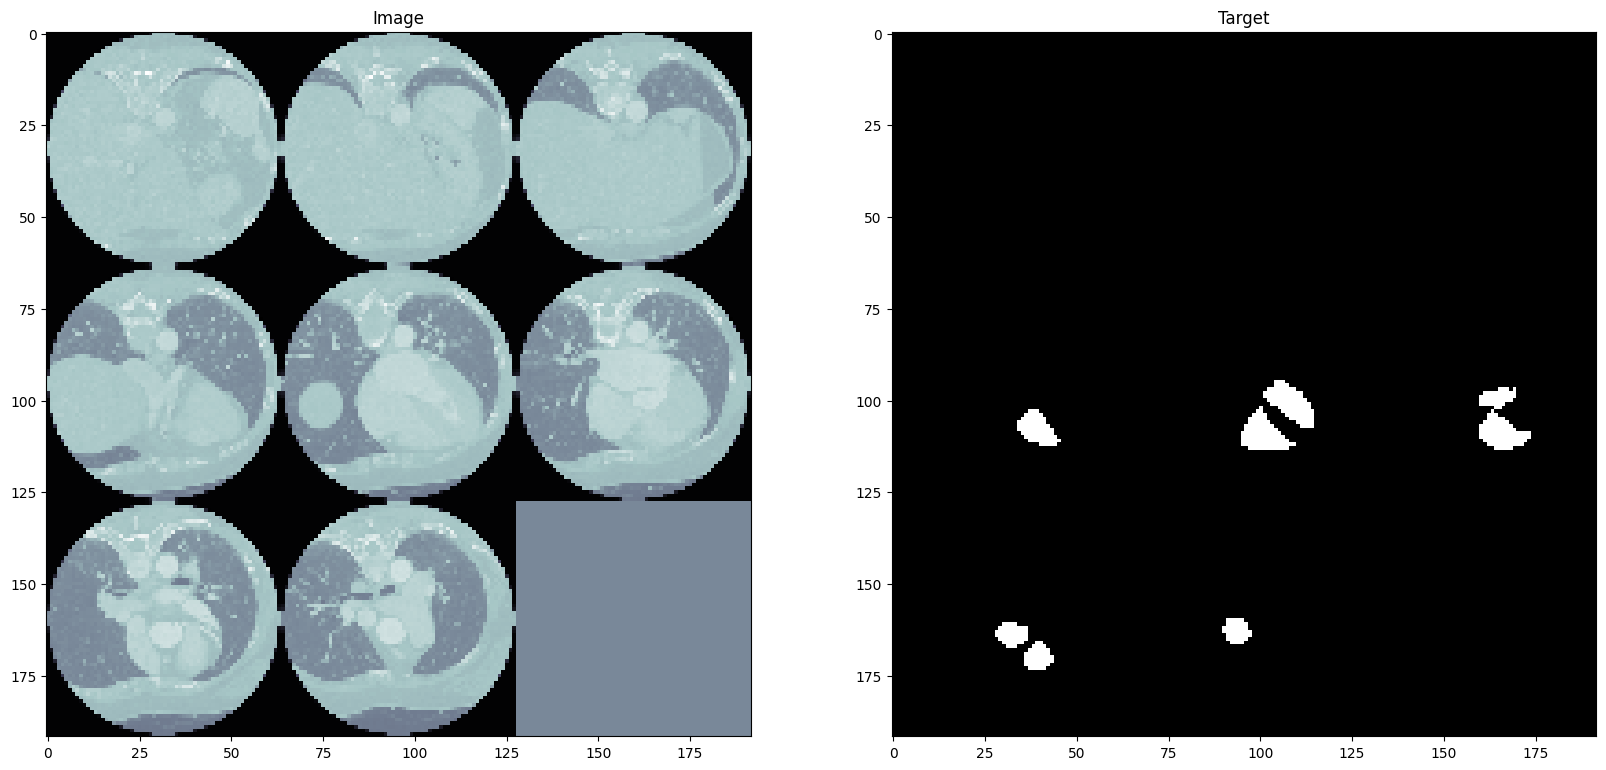

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

idx = 0
image = np.load(dataset["train"][idx]["image"])
label = np.load(dataset["train"][idx]["label"])

print("image:", dataset["train"][idx]["image"], "\n", "shape:", image.shape)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(skimage.util.montage(image.T[0:64:4]), cmap="bone")
ax[1].imshow(skimage.util.montage(label.T[0:64:4]), cmap="grey")
ax[0].set_title("Image")
ax[1].set_title("Target")
pass

## Train Loop

In [14]:
import torch
from heart_seg_app.utils.config import load_config


dataset = load_config(os.path.join(MM_WHS_CHD_LOC_DIR, "dataset.json"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparams = {
    "model": "Unet",
    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": 1e-3,
            "weight_decay": 1e-5,
        }
    },
    "loss_function": "DiceLoss",
    "epochs": 500,
    "batch_size": 64,
    "seed": None,
}

assert dataset["size"] == 88, "Dataset size mismatch"
assert device.type == "cuda", "Device type mismatch"

In [15]:
from monai.data import Dataset, NumpyReader, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd, 
    RandFlipd, RandAffined, RandGaussianNoised, RandGaussianSmoothd, 
    NormalizeIntensityd, RandAdjustContrastd, Rand3DElasticd,
    MapTransform, Transform
)

train_transforms = Compose([
        LoadImaged(keys=["image", "label"], reader=NumpyReader),
        EnsureTyped(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        
        # Spacing
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.5),
        RandAffined(
            keys=["image", "label"], 
            prob=0.7,
            rotate_range=(0.1, 0.1, 0.1), 
            scale_range=(0.1, 0.1, 0.1), 
            translate_range=(5, 5, 5), 
            mode=("bilinear", "nearest")
        ),
        Rand3DElasticd(keys=["image", "label"], prob=0.2, sigma_range=(5, 8), magnitude_range=(100, 200)),

        # Intensity
        NormalizeIntensityd(keys=["image"], channel_wise=True),  # (data - mean) / std
        RandAdjustContrastd(keys=["image"], prob=0.3, gamma=(0.7, 1.5)),
        RandGaussianNoised(keys=["image"], prob=0.15, mean=0, std=0.05),
        RandGaussianSmoothd(keys=["image"], prob=0.1, sigma_x=(0.5, 1.5)),
    ])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureTyped(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys=["image"], channel_wise=True),    
])

train_dataset = Dataset(dataset["train"], transform=train_transforms)
val_dataset = Dataset(dataset["val"], transform=val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

test_dataset = Dataset(dataset["test"], transform=val_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [16]:
from monai.networks.nets import Unet
from monai.losses import DiceLoss
from heart_seg_app.utils.metrics import Dice

model = Unet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters(), **(hyperparams["optimizer"]["params"]))
dice = Dice()

In [56]:
import matplotlib.colors
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.utils import make_grid

def apply_cmap_to_tensor(tensor : torch.Tensor, cmap : matplotlib.colors.Colormap, norm : matplotlib.colors.Normalize = None):
    tensor = tensor.cpu().numpy()
    if norm is not None:
        tensor = norm(tensor)
    tensor = cmap(tensor) # it converts tensor to numpy rgba image with hwc format, .astype(np.float32)
    tensor = torch.from_numpy(tensor)
    tensor = tensor[:,:,:3] # delete alpha channel
    tensor = tensor.permute(2, 0, 1) # hwc -> chw

    return tensor

def make_grid_image_loc(mode : str, image : torch.Tensor,
                        label : torch.Tensor,
                        prediction : torch.Tensor,
                        idx : int) -> torch.Tensor | Image.Image:
    image = image.clone().cpu().squeeze()
    label = label.clone().cpu().squeeze()
    prediction = prediction.clone().cpu().squeeze()
    image = apply_cmap_to_tensor(image[:,:,idx].T, plt.get_cmap("bone"))
    label = (apply_cmap_to_tensor(label[:,:,idx].T, plt.get_cmap("grey")) * 255).int()
    prediction = (apply_cmap_to_tensor(prediction[:,:,idx].T, plt.get_cmap("grey")) * 255).int()
    
    img_grid = make_grid([image, label, prediction])
    if mode == "tensorboard":
        return img_grid
    else:
        img_grid = Image.fromarray((img_grid.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
    return img_grid

In [ ]:
from torch.utils.tensorboard import SummaryWriter

log_dir = "runs/localization"
checkpoint_path = "checkpoints/localization.pth"

# os.makedirs("runs/localization", exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

epochs = 50
threshold = 0.2

best_val_mean_dice = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_mean_dice = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):
        inputs, targets = batch["image"], batch["label"]
        inputs : torch.Tensor; targets : torch.Tensor
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        
        outputs = (torch.sigmoid(outputs) > threshold).int()
        targets = targets.int()
        
        dice(outputs, targets); mean_dice = dice.mean().item()
        train_mean_dice += mean_dice
        
    train_loss /= len(train_dataloader)
    train_mean_dice /= len(train_dataloader)

    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_mean_dice = 0
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch}"):
            inputs, targets = batch["image"], batch["label"]
            inputs : torch.Tensor; targets : torch.Tensor
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
                    
            outputs = (torch.sigmoid(outputs) > threshold).int()
            targets = targets.int()
            
            dice(outputs, targets); mean_dice = dice.mean().item()
            val_mean_dice += mean_dice
        
        val_loss /= len(val_dataloader)
        val_mean_dice /= len(val_dataloader)
    print(f"{epoch+1}/{epochs}: train_loss={train_loss:.5}, train_mean_dice={train_mean_dice:.5}", "\n",
          f"{epoch+1}/{epochs}: val_loss={val_loss:.5}, val_mean_dice={val_mean_dice:.5}")
    
    if val_mean_dice > best_val_mean_dice:
        best_val_mean_dice = val_mean_dice
        torch.save(model.state_dict(), checkpoint_path)
    else:
        print(f"No improvement in val mean dice, skip saving checkpoint\n best_val_mean_dice={best_val_mean_dice:.5}")
    
    writer.add_scalar("Train/loss", train_loss, epoch+1)
    writer.add_scalar("Train/mean_dice", train_mean_dice, epoch+1)
    writer.add_scalar("Val/loss", val_loss, epoch+1)
    writer.add_scalar("Val/mean_dice", val_mean_dice, epoch+1)
    writer.add_scalars("Compare/Loss", {"train": train_loss, "val": val_loss}, epoch+1)
    writer.add_scalars("Compare/MeanDice", {"train": train_mean_dice, "val": val_mean_dice}, epoch+1)
    img_grid = make_grid_image_loc("tensorboard", inputs[0], targets[0], outputs[0], 16)
    writer.add_image("Val/image_grid", img_grid, epoch+1)

### Results Visualization

### Dice Metrics

In [26]:
from monai.networks.nets import Unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.2,
).to(device)

checkpoint_path = "checkpoints/localization_v01.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))

<All keys matched successfully>

In [29]:
from tabulate import tabulate
import pandas as pd
from tqdm import tqdm

table = pd.DataFrame({"idx": [],"mean dice": []})
threshold = 0.2

with torch.no_grad():
    model.eval()
    for batch in tqdm(test_dataloader):
        inputs, targets = batch["image"], batch["label"]
        inputs : torch.Tensor; targets : torch.Tensor
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
                    
        outputs = (torch.sigmoid(outputs) > threshold).int()
        targets = targets.int()
            
        dice(outputs, targets); mean_dice = dice.mean().item()
        
        new_row = pd.DataFrame([["image_idx", mean_dice]], columns=table.columns)
        table = pd.concat([table, new_row], ignore_index=True)

print(tabulate(table, headers=list(table.columns), tablefmt="fancy_grid", numalign="center", floatfmt=".4f"))

100%|██████████| 5/5 [00:00<00:00, 44.84it/s]

╒════╤═══════════╤═════════════╕
│    │ idx       │  mean dice  │
╞════╪═══════════╪═════════════╡
│ 0  │ image_idx │   0.8095    │
├────┼───────────┼─────────────┤
│ 1  │ image_idx │   0.8457    │
├────┼───────────┼─────────────┤
│ 2  │ image_idx │   0.5356    │
├────┼───────────┼─────────────┤
│ 3  │ image_idx │   0.7529    │
├────┼───────────┼─────────────┤
│ 4  │ image_idx │   0.7192    │
╘════╧═══════════╧═════════════╛


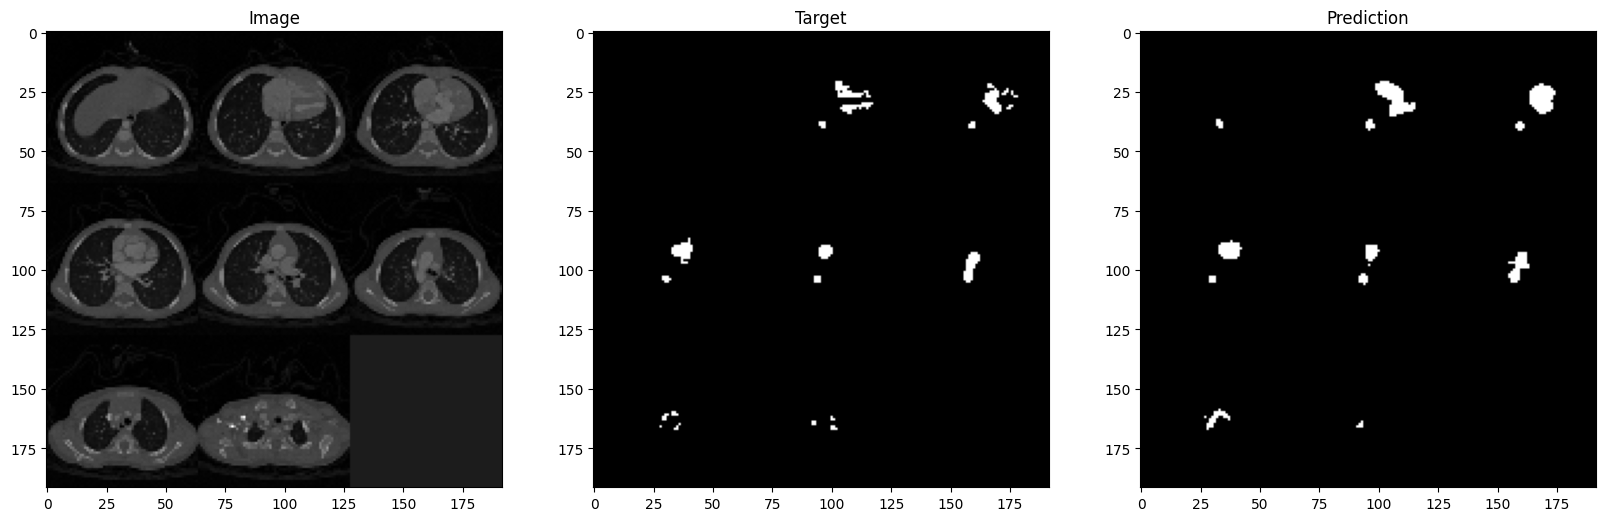

In [ ]:
import skimage
import matplotlib.pyplot as plt

def montage_plot(images : list[torch.Tensor], titles : list[str], start, end, step):
    fig, ax = plt.subplots(1, len(images), figsize=(20, 20)); ax : list[plt.Axes]
    for i, image in enumerate(images):
        image = (torch.Tensor(image)).squeeze().cpu()
        ax[i].imshow(skimage.util.montage(image.T[start:end:step]), cmap="grey")
        ax[i].set_title(titles[i])
    plt.show()

inputs = inputs.squeeze(dim=1)
targets = targets.squeeze(dim=1)
outputs = outputs.squeeze(dim=1)

montage_plot([inputs[0], targets[0], outputs[0]], ["Image", "Target", "Prediction"], 0, 64, 4)

## Prepare & Collect MM-WHS & WHS-CHD Dataset

### MM-WHS Dataset Preprocess

In [43]:
import os
import numpy as np
import re
import torch

ROOT_DIR = "/home/cayetana/Storage/code/heart-segmentation"
os.chdir(ROOT_DIR)

MMWHS_DIR = "data/datasets/MM-WHS 2017 Dataset"
DATASET_DIR = "data/datasets/MM-WHS 2017 & WHS CHD MICCAI19 Datasets"

def collect_data(image_dir : str, label_dir : str) -> list[dict[str, str]]:
    images = sorted(os.listdir(image_dir))
    labels = sorted(os.listdir(label_dir))
    
    data = []
    for image, label in zip(images, labels):
        data.append({"image": os.path.join(image_dir, image),
                     "label": os.path.join(label_dir, label)})
        
    return data

In [44]:
data = collect_data(os.path.join(MMWHS_DIR, "images"),
                    os.path.join(MMWHS_DIR, "labels"))

mmwhs_label_map = {
    "background": {"color": "black", "value": 0.0, "description": "the background"},
    "left ventricle": {"color": "yellow", "value": 500.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 600.0, "description": "the right ventricle blood cavity"},
    "ascending aorta": {"color": "orange", "value": 820.0, "description": "the ascending aorta"},
}

for d in data:
    idx = re.search(r"\d+", os.path.basename(d["image"])).group()
    d["idx"] = int(idx)
    d["meta"] = mmwhs_label_map

data[0]

{'image': 'data/datasets/MM-WHS 2017 Dataset/images/ct_train_1001_image.nii.gz',
 'label': 'data/datasets/MM-WHS 2017 Dataset/labels/ct_train_1001_label.nii.gz',
 'idx': 1001,
 'meta': {'background': {'color': 'black',
   'value': 0.0,
   'description': 'the background'},
  'left ventricle': {'color': 'yellow',
   'value': 500.0,
   'description': 'the left ventricle blood cavity'},
  'right ventricle': {'color': 'skyblue',
   'value': 600.0,
   'description': 'the right ventricle blood cavity'},
  'ascending aorta': {'color': 'orange',
   'value': 820.0,
   'description': 'the ascending aorta'}}}

In [45]:
from monai.data import NumpyReader, NibabelReader, Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureTyped, EnsureChannelFirstd, Spacingd, NormalizeIntensityd,
    Resized,
    MapTransform,
)

transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NibabelReader),
    EnsureTyped(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("trilinear", "nearest")),
    # Resized(keys=["image"], spatial_size=(64, 64, 32), mode="trilinear"),
    # Resized(keys=["label"], spatial_size=(64, 64, 32), mode="nearest"),
    NormalizeIntensityd(keys=["image"], channel_wise=True),
])

mmwhs_dataset = Dataset(data, transform=transforms)
mmwhs_dataloader = DataLoader(mmwhs_dataset, batch_size=1)

In [46]:
from monai.networks.nets import Unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.2,
).to(device)

checkpoint_path = "checkpoints/localization_v01.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))

<All keys matched successfully>

#### Apply Localization Model

In [47]:
def mask_to_bbox(mask : np.ndarray) -> np.ndarray | None:
    coords = np.argwhere(mask > 0)
    
    if len(coords) == 0:
        return None
    
    bbox_min = coords.min(axis=0)
    bbox_max = coords.max(axis=0)
    
    bbox = np.concatenate([bbox_min, bbox_max])
    
    return bbox

def crop_3d_roi(image: np.ndarray, bbox: list, expand_percent : float = 0.0) -> np.ndarray:
    x_size, y_size, z_size = image.shape
    x_min, y_min, z_min, x_max, y_max, z_max = bbox
    x_min = max(0, int(x_min - (x_max - x_min) * expand_percent))
    y_min = max(0, int(y_min - (y_max - y_min) * expand_percent))
    z_min = max(0, int(z_min - (z_max - z_min) * expand_percent))
    x_max = min(x_size, int(x_max + (x_max - x_min) * expand_percent))
    y_max = min(y_size, int(y_max + (y_max - y_min) * expand_percent))
    z_max = min(z_size, int(z_max + (z_max - z_min) * expand_percent))
    
    return image[
        x_min : x_max,
        y_min : y_max,
        z_min : z_max,
    ]

In [48]:
import torch
from scipy.ndimage import zoom
def resize(array : np.ndarray,
           target_size : tuple[int, int, int],
           order : int = 3
           ) -> np.ndarray:
    scales = [ts / s for s, ts in zip(array.shape, target_size)]
    scaled = zoom(array, scales, mode="reflect", order=order)
    
    return scaled

In [49]:
from tqdm import tqdm

threshold = 0.2
mask_size = (64, 64, 32)
expand_percent = 0.1
target_size = (128, 128, 128)
prefix = "mm-whs"
label_values = [meta["value"] for meta in mmwhs_label_map.values()]

for patient in tqdm(mmwhs_dataloader, desc="Localization Progress : "):
    patient : dict[str,  torch.Tensor]
    idx = patient["idx"].item()
    image, label = patient["image"], patient["label"]
    model.eval()
    with torch.no_grad():
        image_resized = torch.tensor(resize(image, target_size=((1, 1) + mask_size), order=3), device=device)
        mask = model(image_resized); mask : torch.Tensor
        mask = (torch.sigmoid(mask) > threshold).int()
        
        image = image.squeeze().cpu().numpy()
        label = label.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()
    
        image = resize(image, target_size=target_size, order=3)
        label = resize(label, target_size=target_size, order=0)
        mask = resize(mask, target_size=target_size, order=0)
        bbox = mask_to_bbox(mask)
        
        roi_image = crop_3d_roi(image, bbox, expand_percent)
        roi_label = crop_3d_roi(label, bbox, expand_percent)
        
        roi_image = resize(roi_image, target_size=target_size, order=3)
        roi_label = resize(roi_label, target_size=target_size, order=0)
        
        # keep only used label values
        roi_label *= np.isin(roi_label, label_values)
        assert np.all(np.unique(roi_label) == np.array(label_values))

        for i, label_value in enumerate(label_values):
            roi_label[roi_label == label_value] = i
        assert np.all(np.unique(roi_label) == np.array(range(4)))
        
        assert roi_image.shape == target_size
        assert roi_label.shape == target_size
        
        np.save(os.path.join(DATASET_DIR, "images", f"{prefix}_{idx}_image.npy"), roi_image)
        np.save(os.path.join(DATASET_DIR, "labels", f"{prefix}_{idx}_label.npy"), roi_label)

Localization Progress : 100%|██████████| 20/20 [02:44<00:00,  8.24s/it]


In [50]:
import matplotlib.pyplot as plt
import skimage

def display_image_montages(images : list[torch.Tensor], titles : list[str], cmaps : list, norms : list, start, end, step):
    fig, ax = plt.subplots(1, len(images), figsize=(20, 20)); ax : list[plt.Axes]
    for i, image in enumerate(images):
        image = (torch.Tensor(image)).squeeze().cpu()
        ax[i].imshow(skimage.util.montage(image.T[start:end:step]), cmap=cmaps[i], norm=norms[i])
        ax[i].set_title(titles[i])
    plt.show()

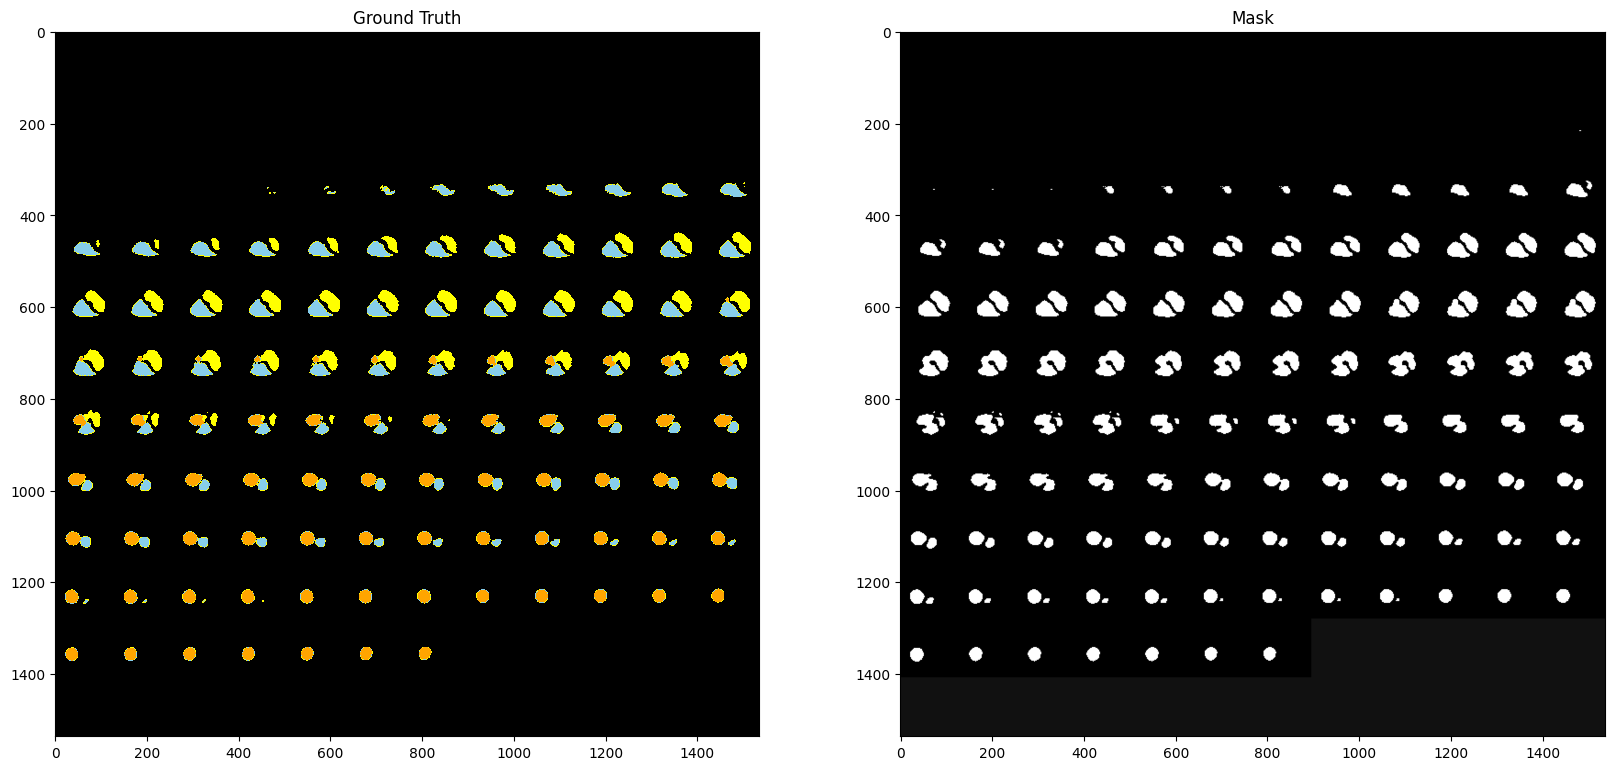

In [57]:
from heart_seg_app.utils.visualization import create_custom_cmap

label_map = {
    "background": {"color": "black", "value": 0.0},
    "left ventricle": {"color": "yellow", "value": 500.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 600.0, "description": "the right ventricle blood cavity"},
    "ascending aorta": {"color": "orange", "value": 820.0, "description": "the ascending aorta"},
}
colors = [meta["color"] for meta in label_map.values()]
label_values = [meta["value"] for meta in label_map.values()]
label_values, colors = zip(*sorted(zip(label_values, colors)))
label_cmap, label_norm = create_custom_cmap(label_values, colors)

label *= np.isin(label, label_values)
display_image_montages([label, mask],
                       ["Ground Truth", "Mask"],
                       [label_cmap, "grey"],
                       [label_norm, None],
                       start=0, end=127, step=1)

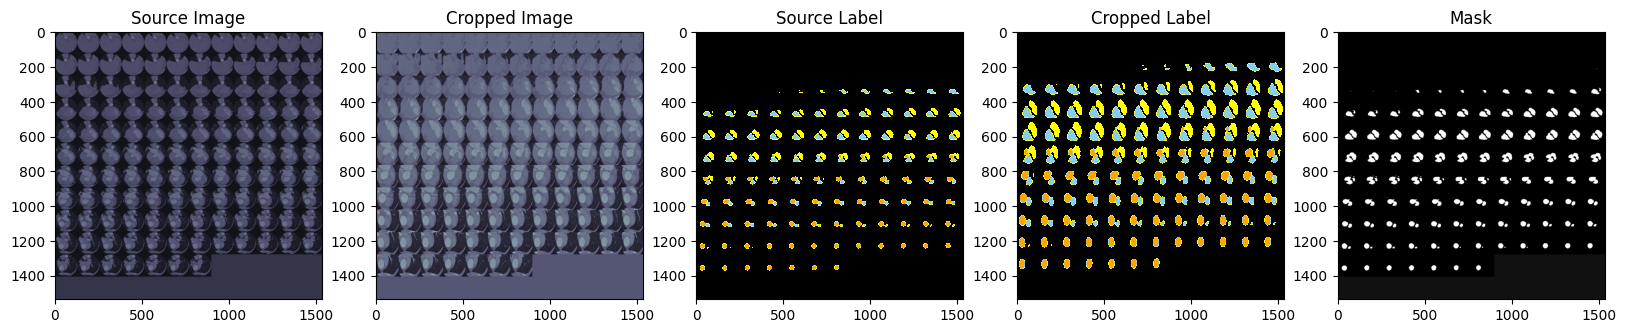

In [62]:
roi_label_cmap, roi_label_norm = create_custom_cmap(list(range(4)), colors)
display_image_montages(images=[image, roi_image, label, roi_label, mask],
                       titles=["Source Image", "Cropped Image", "Source Label", "Cropped Label", "Mask"],
                       cmaps=["bone", "bone", label_cmap, roi_label_cmap, "gray"],
                       norms=[None, None, label_norm, roi_label_norm, None],
                       start=0, end=127, step=1)

### WHS-CHD Dataset Preprocess

In [63]:
import os
import numpy as np
import re
import torch

ROOT_DIR = "/home/cayetana/Storage/code/heart-segmentation"
os.chdir(ROOT_DIR)

WHS_CHD_DIR = "data/datasets/WHS CHD MICCAI19 Dataset"
DATASET_DIR = "data/datasets/MM-WHS 2017 & WHS CHD MICCAI19 Datasets"

def collect_data(image_dir : str, label_dir : str) -> list[dict[str, str]]:
    images = sorted(os.listdir(image_dir))
    labels = sorted(os.listdir(label_dir))
    
    data = []
    for image, label in zip(images, labels):
        data.append({"image": os.path.join(image_dir, image),
                     "label": os.path.join(label_dir, label)})
        
    return data

In [64]:
data = collect_data(os.path.join(WHS_CHD_DIR, "images"),
                    os.path.join(WHS_CHD_DIR, "labels"))

whs_chd_label_map = {
    "background": {"color": "black", "value": 0.0, "description": "the background"},
    "left ventricle": {"color": "yellow", "value": 1.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 2.0, "description": "the right ventricle blood cavity"},
    "ascending aorta": {"color": "orange", "value": 6.0, "description": "the ascending aorta"},
}

for d in data:
    idx = re.search(r"\d+", os.path.basename(d["image"])).group()
    d["idx"] = int(idx)
    d["meta"] = whs_chd_label_map

assert len(data) == 68, "Dataset size does not match"

data[0]

{'image': 'data/datasets/WHS CHD MICCAI19 Dataset/images/ct_1001_image.nii.gz',
 'label': 'data/datasets/WHS CHD MICCAI19 Dataset/labels/ct_1001_label.nii.gz',
 'idx': 1001,
 'meta': {'background': {'color': 'black',
   'value': 0.0,
   'description': 'the background'},
  'left ventricle': {'color': 'yellow',
   'value': 1.0,
   'description': 'the left ventricle blood cavity'},
  'right ventricle': {'color': 'skyblue',
   'value': 2.0,
   'description': 'the right ventricle blood cavity'},
  'ascending aorta': {'color': 'orange',
   'value': 6.0,
   'description': 'the ascending aorta'}}}

In [67]:
from monai.data import NibabelReader, Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureTyped, EnsureChannelFirstd, Spacingd, NormalizeIntensityd,
)

transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NibabelReader),
    EnsureTyped(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("trilinear", "nearest")),
    # Resized(keys=["image"], spatial_size=(64, 64, 32), mode="trilinear"),
    # Resized(keys=["label"], spatial_size=(64, 64, 32), mode="nearest"),
    NormalizeIntensityd(keys=["image"], channel_wise=True),
])

whschd_dataset = Dataset(data, transform=transforms)
whschd_dataloader = DataLoader(whschd_dataset, batch_size=1)

assert len(whschd_dataloader) == 68

In [68]:
from monai.networks.nets import Unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.2,
).to(device)

checkpoint_path = "checkpoints/localization_v01.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))

<All keys matched successfully>

#### Apply Localization Model

In [70]:
from tqdm import tqdm

threshold = 0.2
mask_size = (64, 64, 32)
expand_percent = 0.1
target_size = (128, 128, 128)
prefix = "whs-chd"
label_values = [meta["value"] for meta in whs_chd_label_map.values()]

for patient in tqdm(whschd_dataloader, desc="Localization Progress : "):
    patient : dict[str,  torch.Tensor]
    idx = patient["idx"].item()
    image, label = patient["image"], patient["label"]
    model.eval()
    with torch.no_grad():
        image_resized = torch.tensor(resize(image, target_size=((1, 1) + mask_size), order=3), device=device)
        mask = model(image_resized); mask : torch.Tensor
        mask = (torch.sigmoid(mask) > threshold).int()
    
        image = image.squeeze().cpu().numpy()
        label = label.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()
        
        image = resize(image, target_size=target_size, order=3)
        label = resize(label, target_size=target_size, order=0)
        mask = resize(mask, target_size=target_size, order=0)
        bbox = mask_to_bbox(mask)

        roi_image = crop_3d_roi(image, bbox, expand_percent)
        roi_label = crop_3d_roi(label, bbox, expand_percent)

        roi_image = resize(roi_image, target_size=target_size, order=3)
        roi_label = resize(roi_label, target_size=target_size, order=0)
        
        # keep only used label values
        roi_label *= np.isin(roi_label, label_values)
        assert np.all(np.unique(roi_label) == np.array(label_values))

        for i, label_value in enumerate(label_values):
            roi_label[roi_label == label_value] = i
        assert np.all(np.unique(roi_label) == np.array(range(4)))

        assert roi_image.shape == target_size
        assert roi_label.shape == target_size
        
        np.save(os.path.join(DATASET_DIR, "images", f"{prefix}_{idx}_image.npy"), roi_image)
        np.save(os.path.join(DATASET_DIR, "labels", f"{prefix}_{idx}_label.npy"), roi_label)

Localization Progress : 100%|██████████| 68/68 [09:20<00:00,  8.25s/it]


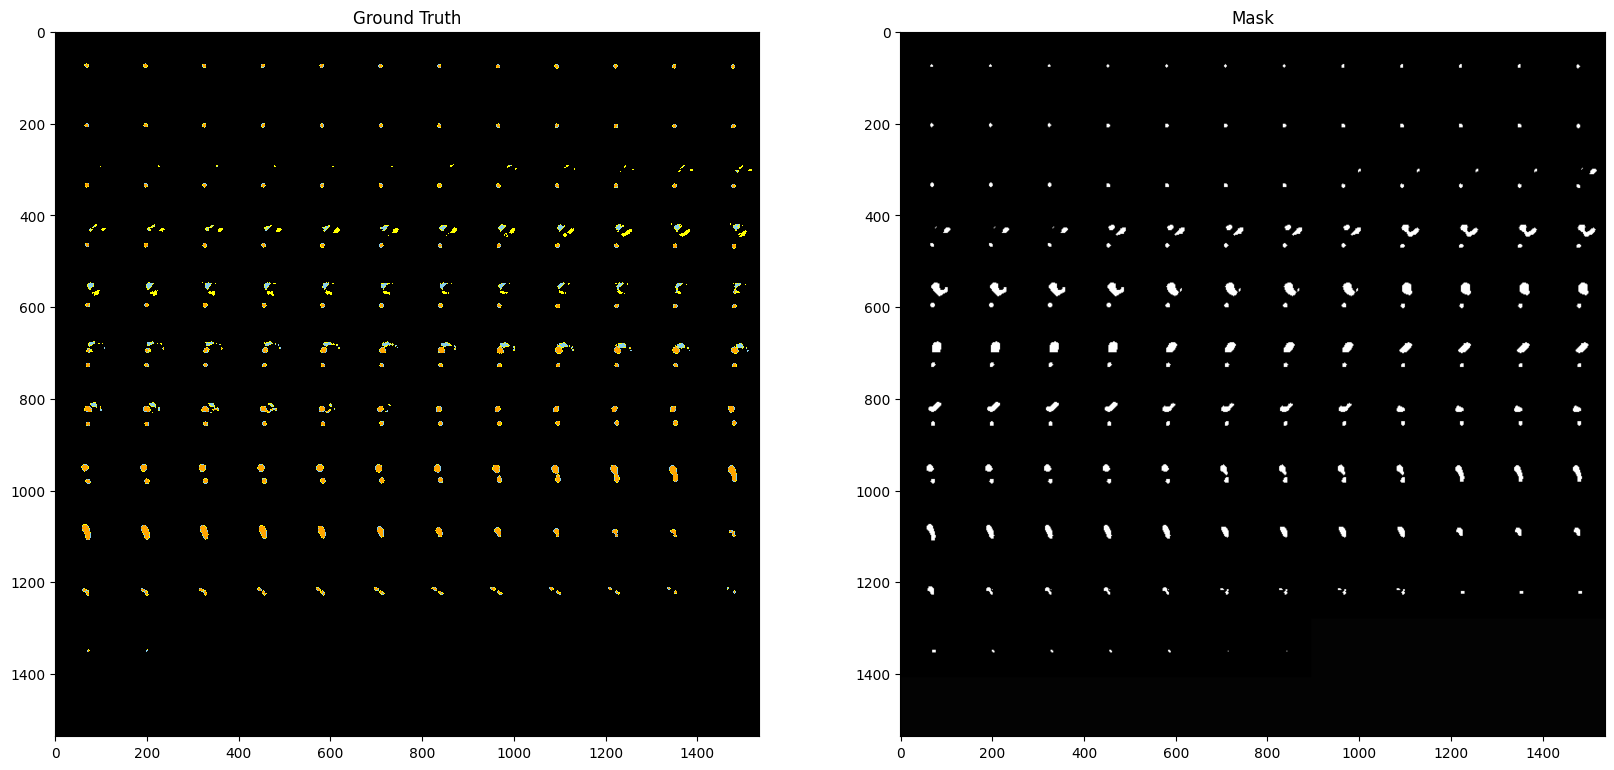

In [74]:
from heart_seg_app.utils.visualization import create_custom_cmap

colors = [meta["color"] for meta in whs_chd_label_map.values()]
label_values = [meta["value"] for meta in whs_chd_label_map.values()]
label_cmap, label_norm = create_custom_cmap(label_values, colors)

label *= np.isin(label, label_values)
display_image_montages([label, mask],
                       ["Ground Truth", "Mask"],
                       [label_cmap, "grey"],
                       [label_norm, None],
                       start=0, end=127, step=1)

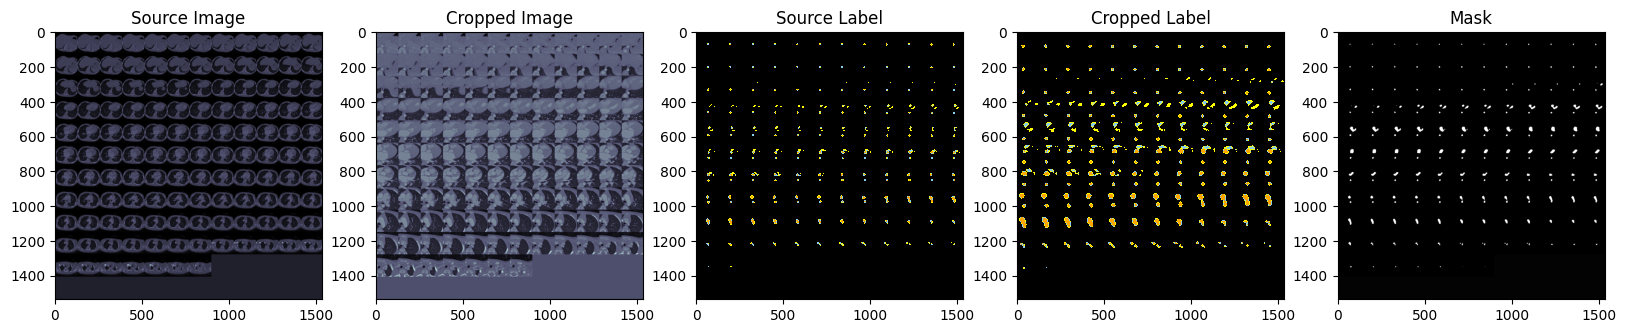

In [75]:
roi_label_cmap, roi_label_norm = create_custom_cmap(list(range(4)), colors)
display_image_montages(images=[image, roi_image, label, roi_label, mask],
                       titles=["Source Image", "Cropped Image", "Source Label", "Cropped Label", "Mask"],
                       cmaps=["bone", "bone", label_cmap, roi_label_cmap, "gray"],
                       norms=[None, None, label_norm, roi_label_norm, None],
                       start=0, end=127, step=1)

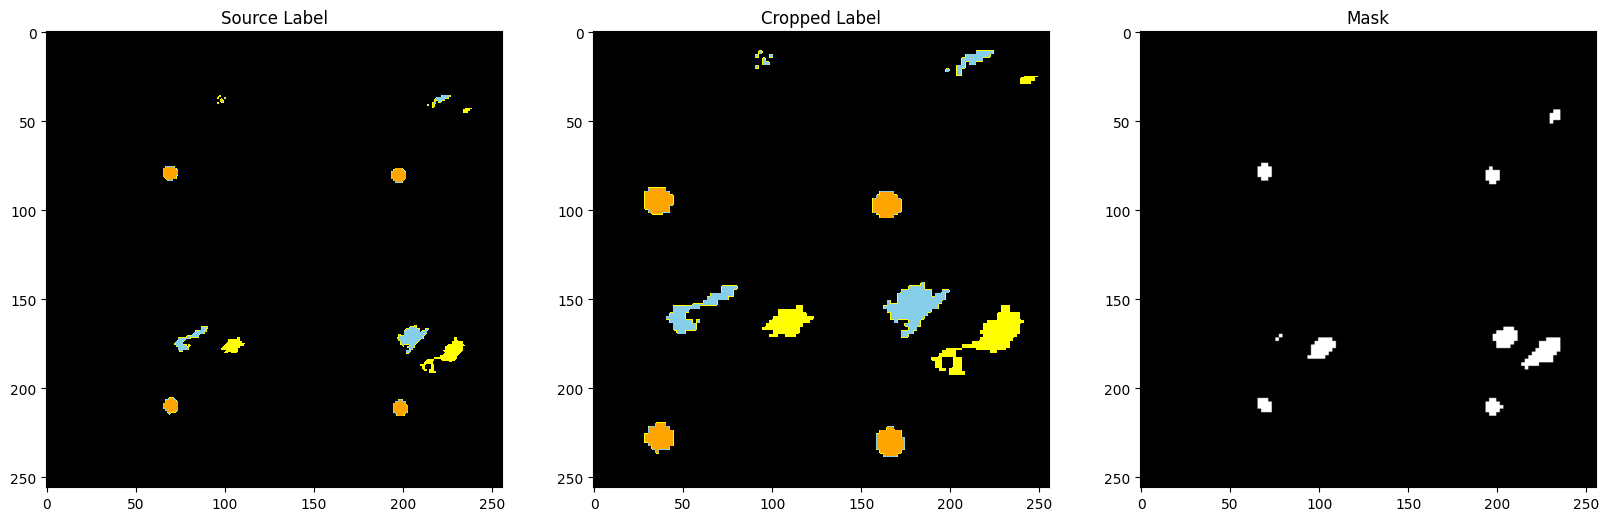

In [87]:
display_image_montages(images=[label, roi_label, mask],
                       titles=["Source Label", "Cropped Label", "Mask"],
                       cmaps=[label_cmap, roi_label_cmap, "gray"],
                       norms=[label_norm, roi_label_norm, None],
                       start=25, end=49, step=6)

### Split & Save Config

In [88]:
DATASET_DIR = "data/datasets/MM-WHS 2017 & WHS CHD MICCAI19 Datasets"

data = collect_data(os.path.join(DATASET_DIR, "images"),
                             os.path.join(DATASET_DIR, "labels"))

label_map = {
    "background": {"color": "black", "value": 0.0, "description": "the background"},
    "left ventricle": {"color": "yellow", "value": 1.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 2.0, "description": "the right ventricle blood cavity"},
    "ascending aorta": {"color": "orange", "value": 6.0, "description": "the ascending aorta"},
}

for d in data:
    idx = re.search(r"\d+", os.path.basename(d["image"])).group()
    # d["meta"] = label_map

assert len(data) == 88

data[0]

{'image': 'data/datasets/MM-WHS 2017 & WHS CHD MICCAI19 Datasets/images/mm-whs_1001_image.npy',
 'label': 'data/datasets/MM-WHS 2017 & WHS CHD MICCAI19 Datasets/labels/mm-whs_1001_label.npy'}

In [89]:
from heart_seg_app.utils.config import save_config

from heart_seg_app.utils.dataset import split_dataset
from heart_seg_app.utils.config import save_config

dataset = {
    "sources": ["https://zmiclab.github.io/zxh/0/mmwhs/",
                "https://www.kaggle.com/datasets/xiaoweixumedicalai/chd68-segmentation-dataset-miccai19"],
    "size": 0,
    "train": [],
    "val": [],
    "test": [],
}

split_ratios = (0.75, 0.2, 0.05)
seed = 42

splited_dataset = split_dataset(data, split_ratios=split_ratios, seed=seed)

dataset["train"] += splited_dataset["train"]
dataset["val"] += splited_dataset["val"]
dataset["test"] += splited_dataset["test"]
dataset["size"] += len(data)

save_config(dataset, os.path.join(DATASET_DIR, "dataset.json"))